# Natural Language Processing with Disaster Tweets

This notebook aims to build a deep learning model that classifies tweets as being about a real natural disaster or not. This is a supervised text classificatoion problem with a binary target variable. The training set consists of 7601 examples of the tweets, their location and any keywords associated with the tweet. The location and keyword feautres have a lot of missing values. 

To start, we will do some EDA and preprocessing of the text to get it formatted properly for the analysis. Then we will test a few different model architectures and experiment with tuning some of the hyperparameters. 

Achieving the highest accuracy on the (unlabeled) test set is our ultimate goal. The final models will be evaluated on the test set once the predictions are submitted to the competition.

## Import Libraries

In [1]:
# Import Libraries
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import WordPunctTokenizer

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
tf.config.run_functions_eagerly(True)

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

punct = nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
nltk.download('omw-1.4')

# This step breaks down words to their roots (stems and lemma)
lemma = WordNetLemmatizer()
stemm = PorterStemmer()
tokenize = WordPunctTokenizer()
%matplotlib inline

2023-02-24 09:08:51.445380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /Users/Wee-YO/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Wee-
[nltk_data]     YO/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Wee-YO/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Wee-YO/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Exploratory Data Analysis


In [2]:
# Load Train Dataset
train_df = pd.read_csv("train.csv")
print(f"There are {len(train_df)} examples in the training data")
train_df.head()

There are 7613 examples in the training data


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


/Users/Wee-YO/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


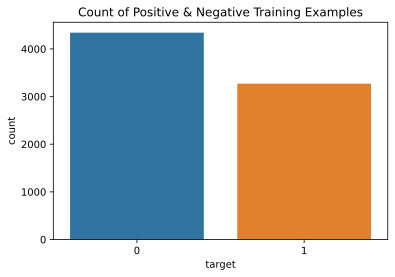

In [4]:
plt.title('Count of Positive & Negative Training Examples')
sns.countplot(train_df.target);

In [5]:
# 10 most common keywords in the training data
train_df.keyword.value_counts()[0:10]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: keyword, dtype: int64

In [6]:
# 10 Most Common Keywords of Real Disaster Tweets in Training Data
train_df[train_df.target == 1].keyword.value_counts()[0:10]

derailment           39
wreckage             39
outbreak             39
debris               37
oil%20spill          37
typhoon              37
evacuated            32
suicide%20bombing    32
rescuers             32
suicide%20bomb       32
Name: keyword, dtype: int64

In [7]:
# 10 Most Common Keywords of Non-Disaster Tweets in Training Data
train_df[train_df.target == 0].keyword.value_counts()[0:10]

body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
twister        35
fear           35
siren          35
Name: keyword, dtype: int64

In [8]:
# 10 Most Common Locations of Real Disaster Tweets in Training Data
train_df[train_df.target == 1].location.value_counts()[0:10]

USA               67
United States     27
Nigeria           22
India             20
Mumbai            19
UK                16
London            16
New York          16
Washington, DC    15
Canada            13
Name: location, dtype: int64

In [9]:
# 10 Most Common Locations of Non-Disaster Tweets in Training Data
train_df[train_df.target == 0].location.value_counts()[0:10]

New York           55
USA                37
London             29
United States      23
Los Angeles, CA    18
Canada             16
Kenya              15
Everywhere         12
Florida            11
UK                 11
Name: location, dtype: int64

The location and keyword features seem to contain some useful information, as the top keywords and locations have some differences that could provide a useful signal during training. 

The plan of analysis will be to clean the data, set up the dataset for NLP and experiment with some different values for preparing the dataset. Then we will test a few diferent model architectures and finally tune hyperparameters for the most promising architecture. 

### Data Cleaning 

Cleaning and formatting are very important steps in language data, because text can be prone to all sorts of irregularities. First we will deal with missing values (NaNs) and duplicates.

The text preprocessing steps are as follows:
1. Convert the whole data into lower case.
2. Remove numbers, html tags, urls, and punctuations.
3. Tokenize the text using Word Tokenize function.
4. Remove all stop words from the data.
5. Retrieve the text into their base form using the stemming and lemmatization function.

In [10]:
train_df.notna().value_counts()

id    keyword  location  text  target
True  True     True      True  True      5080
               False     True  True      2472
      False    False     True  True        61
dtype: int64

The keyword and locaton variables have a lot of NaN values. However they may still have useful information so we will leave them in. However we will need to fill in the missing values with an empty string to make them compatible with the model training. 

In [11]:
train_df = train_df.fillna('')
train_df.notna().value_counts()

id    keyword  location  text  target
True  True     True      True  True      7613
dtype: int64

There are also a small number of duplicated text examples in the datast, so we will drop them and add checks for unique texts and to detect null values. 

In [12]:
train_df = train_df.drop_duplicates('text')

assert len(train_df) == len(train_df.text.unique()), 'There are duplicate values'
assert len(train_df) == len(train_df.text.notna()), 'There are null values'

In [13]:
# Load test data and remove NA values
test_df = pd.read_csv("test.csv")
test_df = test_df.fillna('')

assert len(test_df) == len(test_df.text.notna()), 'There are null values'
test_df.head()

,id,keyword,location,text
0,0,,,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s..."
2,3,,,"there is a forest fire at spot pond, geese are..."
3,9,,,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan


In [16]:
# Clean and Format Text 

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove web links
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    text = str(text.lower()) # convert all to lower case
    text = re.sub('\d+', '', text) # remove numbers
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text) # remove punctuation
    text = ' '.join(lemma.lemmatize(word) for word in text.split(' ')) #lemmatize words
    return text

# apply to train dataframe
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))

The next step is to tokenize the text. To do this we need to choose a few parameters:

* Vocabulary Size - The number of words included. Too large of a vocabulary and you include a lot of minor or rare words. Too few words and you risk losing valuable data.
* num_words - The amount of words to keep after tokenization. This parameter filters out words with a low occurrence. 
* batch size - Influences training speed and can influence overfitting.
* max_length - The maximum length of the tokens. 

After some testing I decided on a vocabulary size of 10000 and a num_words of 2000. A batch size of 128 seems to be a good fit for training this model. The max_len does not change much so I will set it to 21, but could easily have chosen a slightly different number. 

In [18]:
# Create Validation Set with 10% of training data and remove from training data
features, labels= train_df['text'], train_df['target']

train_features, val_features, train_targets, val_targets = train_test_split(
        features, labels,
        train_size=0.9,
        random_state=12,
        shuffle = True,
        stratify = labels)

# Format Data for use with Tensorflow / Keras
train_data = tf.data.Dataset.from_tensor_slices((train_features.to_numpy(), train_targets.to_numpy())) 
val_data = tf.data.Dataset.from_tensor_slices((val_features.to_numpy(),val_targets.to_numpy()))

# Testing found that a batch size of 128 is a good size for training
BUFFER_SIZE = 1000
BATCH_SIZE = 128

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_data = val_data.batch(BATCH_SIZE)

# Testing Found that a Vocab size of 10000 and keeping the top 2000 produced best results
vocab_size = 10000
max_len = 21

vectorize_layer = TextVectorization(
    max_tokens=vocab_size + 2,
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_len,
)

vectorize_layer.adapt(train_data.map(lambda text, label: text))
vectorize_layer.adapt(val_data.map(lambda text, label: text))

vocab = np.array(vectorize_layer.get_vocabulary())

# Tokenize the texts - num_wods is the maximum to keep
tokenizer = Tokenizer(num_words = 2000, split=' ')

tokenizer.fit_on_texts(train_features.values)     # convert text into numerical data
train_features = tokenizer.texts_to_sequences(train_features.values)

train_features = pad_sequences(train_features,
                                maxlen = max_len,
                                padding = 'post',
                                truncating = 'post')

/Users/Wee-YO/miniconda3/envs/py39/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


## Analysis - Model Building & Training

This notebook will explore three model architectures:

* Dense Neural Network 
* LSTM Network (with some variations)
* GRU

The training data is small for this project, so we can test out a few diffeent architectures without spending too much time on training. 

During training we will need to be careful to avoid overfitting to the training data. To observe possible overfitting, we created a validation set of 10% of the training data to test during training. When there is a divergence between the validation and training accuracies during training, where training accuracy becomes very high while the validation accuracy is stagnant or decreasing across epochs, then we have evidence the model is overfitting to the training data and will not generalize well to unseen data.

A good way to avoid overfitting to the training data is to use dropout regularization. While working on this project it was found that dropout regularization rates of 0.3-0.4 achieved the best scores on the vaildation set during training, so a dropout rate of 0.4 is used as a default in all three model architectures. 

#### Dense Network

First we will try a simple Dense Neural Network, also called a multi-layer perceptron in our class lectures. This will be a simple baseline for the future models.

In [19]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = max_len, mask_zero=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')])
    
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_data, epochs=10, validation_data = val_data)

Epoch 1/10
53/53 [==============================] - 4s 57ms/step - loss: 0.6751 - accuracy: 0.5733 - val_loss: 0.6567 - val_accuracy: 0.5752
Epoch 2/10
53/53 [==============================] - 3s 58ms/step - loss: 0.6262 - accuracy: 0.6515 - val_loss: 0.5978 - val_accuracy: 0.7736
Epoch 3/10
53/53 [==============================] - 3s 56ms/step - loss: 0.5546 - accuracy: 0.7626 - val_loss: 0.5258 - val_accuracy: 0.7856
Epoch 4/10
53/53 [==============================] - 3s 58ms/step - loss: 0.4814 - accuracy: 0.8132 - val_loss: 0.4811 - val_accuracy: 0.7949
Epoch 5/10
53/53 [==============================] - 3s 57ms/step - loss: 0.4296 - accuracy: 0.8286 - val_loss: 0.4667 - val_accuracy: 0.7856
Epoch 6/10
53/53 [==============================] - 4s 68ms/step - loss: 0.3955 - accuracy: 0.8393 - val_loss: 0.4688 - val_accuracy: 0.7790
Epoch 7/10
53/53 [==============================] - 3s 60ms/step - loss: 0.3709 - accuracy: 0.8523 - val_loss: 0.4802 - val_accuracy: 0.7723
Epoch 8/10
53

Best Val Acc: 0.795 on epoch 4 with training accuracy of 0.813


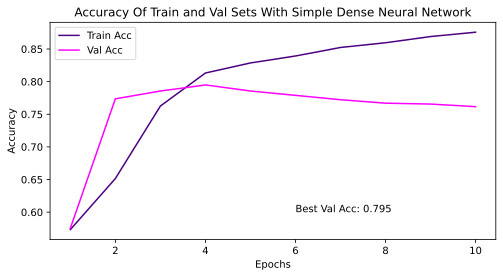

In [20]:
plt.figure(figsize=(8,4))
plt.title(f'Accuracy Of Train and Val Sets With Simple Dense Neural Network')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(history.history['val_accuracy']):.3} on epoch 4 with training accuracy of {history.history['accuracy'][3]:.3}")
    
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'indigo');
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'magenta')
plt.text(6, 0.6, f"Best Val Acc: {max(history.history['val_accuracy']):.3}" )
plt.legend(['Train Acc', 'Val Acc'])
    
plt.show()

#### LSTM Model - Simplified Architecture

For the RNN models we'll start with training a simple LSTM model to see if it can produce an accurate model while avoiding overfitting.

In [21]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = max_len, mask_zero=True),
    tf.keras.layers.LSTM(4),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1,activation='sigmoid')])

model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])    
history = model.fit(train_data, epochs=10, validation_data= val_data)

Epoch 1/10
53/53 [==============================] - 13s 247ms/step - loss: 0.6856 - accuracy: 0.5764 - val_loss: 0.6772 - val_accuracy: 0.5819
Epoch 2/10
53/53 [==============================] - 11s 214ms/step - loss: 0.6551 - accuracy: 0.6132 - val_loss: 0.6189 - val_accuracy: 0.7603
Epoch 3/10
53/53 [==============================] - 11s 203ms/step - loss: 0.5788 - accuracy: 0.7550 - val_loss: 0.5423 - val_accuracy: 0.7896
Epoch 4/10
53/53 [==============================] - 11s 200ms/step - loss: 0.5157 - accuracy: 0.8172 - val_loss: 0.5178 - val_accuracy: 0.7816
Epoch 5/10
53/53 [==============================] - 11s 198ms/step - loss: 0.4733 - accuracy: 0.8411 - val_loss: 0.5079 - val_accuracy: 0.7750
Epoch 6/10
53/53 [==============================] - 11s 199ms/step - loss: 0.4401 - accuracy: 0.8552 - val_loss: 0.5095 - val_accuracy: 0.7630
Epoch 7/10
53/53 [==============================] - 10s 197ms/step - loss: 0.4113 - accuracy: 0.8667 - val_loss: 0.5080 - val_accuracy: 0.7643

Best Val Acc: 0.79 on epoch 3/10 with training accuracy of 0.755


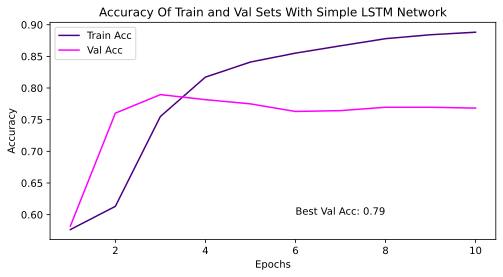

In [22]:
plt.figure(figsize=(8,4))
plt.title(f'Accuracy Of Train and Val Sets With Simple LSTM Network')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(history.history['val_accuracy']):.3} on epoch 3/10 with training accuracy of {history.history['accuracy'][2]:.3}")
   
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'indigo');
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'magenta')
plt.text(6, 0.6, f"Best Val Acc: {max(history.history['val_accuracy']):.3}" )
plt.legend(['Train Acc', 'Val Acc'])
    
plt.show()

#### Deeper / More Complex LSTM Network

More complex architectures are better at learning complex data, but will take longer to train and may be prone to overfitting. There are a few different ways to build this type of model, with different groupings of LSTM and dense layers. 

Here we'll use a bidirectional LSTM with 64 and 32 units, in combination with Dense layers and dropout regularization to prevent overfitting to the training data.

In [23]:
histories = []

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim= vocab_size+1,output_dim=max_len,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='tanh',return_sequences=False)),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1,activation='sigmoid')])


model.compile(loss='binary_crossentropy',optimizer= 'adam', metrics=['accuracy'])
history = model.fit(train_data, epochs=10, validation_data= val_data)

Epoch 1/10
53/53 [==============================] - 48s 900ms/step - loss: 0.6640 - accuracy: 0.5906 - val_loss: 0.6162 - val_accuracy: 0.6485
Epoch 2/10
53/53 [==============================] - 51s 954ms/step - loss: 0.4866 - accuracy: 0.8039 - val_loss: 0.5130 - val_accuracy: 0.7590
Epoch 3/10
53/53 [==============================] - 51s 972ms/step - loss: 0.4122 - accuracy: 0.8424 - val_loss: 0.5454 - val_accuracy: 0.7630
Epoch 4/10
53/53 [==============================] - 52s 978ms/step - loss: 0.3640 - accuracy: 0.8672 - val_loss: 0.6239 - val_accuracy: 0.7417
Epoch 5/10
53/53 [==============================] - 50s 942ms/step - loss: 0.3270 - accuracy: 0.8836 - val_loss: 0.6778 - val_accuracy: 0.7710
Epoch 6/10
53/53 [==============================] - 52s 978ms/step - loss: 0.2917 - accuracy: 0.8963 - val_loss: 0.7316 - val_accuracy: 0.7523
Epoch 7/10
53/53 [==============================] - 81s 2s/step - loss: 0.2708 - accuracy: 0.9061 - val_loss: 0.7908 - val_accuracy: 0.7550
Ep

Best Val Acc: 0.771 on epoch 5/10 with training accuracy of 0.906


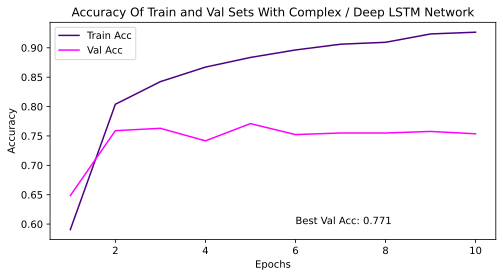

In [24]:
plt.figure(figsize=(8,4))
plt.title(f'Accuracy Of Train and Val Sets With Complex / Deep LSTM Network')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(history.history['val_accuracy']):.3} on epoch 5/10 with training accuracy of {history.history['accuracy'][6]:.3}")
   
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'indigo');
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'magenta')
plt.text(6, 0.6, f"Best Val Acc: {max(history.history['val_accuracy']):.3}" )
plt.legend(['Train Acc', 'Val Acc'])
    
plt.show()

### Bidirectional LSTM With Added Dense Layers

This model architecture combines the advantages of the dense and LSTM approaches. We use the LSTM in the beginning and then pass the LSTM output to a series of dense layers.

This model takes a little longer to train than either the dense or RNN approach on it's own. 

In [27]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim= vocab_size+1,output_dim=max_len,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=False)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')])

model.compile(loss='binary_crossentropy',optimizer= 'adam', metrics=['accuracy'])
history = model.fit(train_data, epochs=6, validation_data= val_data)

Epoch 1/6
53/53 [==============================] - 28s 519ms/step - loss: 0.6519 - accuracy: 0.6012 - val_loss: 0.5656 - val_accuracy: 0.6605
Epoch 2/6
53/53 [==============================] - 29s 545ms/step - loss: 0.4414 - accuracy: 0.8063 - val_loss: 0.4850 - val_accuracy: 0.7790
Epoch 3/6
53/53 [==============================] - 28s 536ms/step - loss: 0.3684 - accuracy: 0.8504 - val_loss: 0.5652 - val_accuracy: 0.7603
Epoch 4/6
53/53 [==============================] - 30s 559ms/step - loss: 0.3252 - accuracy: 0.8743 - val_loss: 0.5838 - val_accuracy: 0.7643
Epoch 5/6
53/53 [==============================] - 31s 570ms/step - loss: 0.2921 - accuracy: 0.8923 - val_loss: 0.6434 - val_accuracy: 0.7523
Epoch 6/6
53/53 [==============================] - 25s 472ms/step - loss: 0.2555 - accuracy: 0.9077 - val_loss: 0.8165 - val_accuracy: 0.7483


Best Val Acc: 0.779 on epoch 2/6 with training accuracy of 0.85


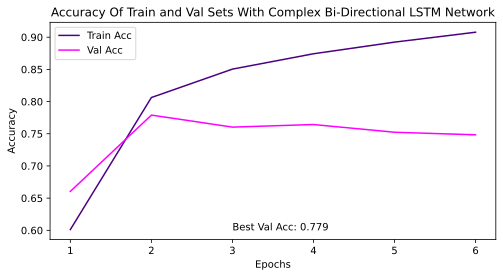

In [29]:
plt.figure(figsize=(8,4))
plt.title(f'Accuracy Of Train and Val Sets With Complex Bi-Directional LSTM Network')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
    
print(f"Best Val Acc: {max(history.history['val_accuracy']):.3} on epoch 2/6 with training accuracy of {history.history['accuracy'][2]:.3}")
   
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'indigo');
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'magenta')
plt.text(3, 0.6, f"Best Val Acc: {max(history.history['val_accuracy']):.3}" )
plt.legend(['Train Acc', 'Val Acc'])
    
plt.show()

### GRU Model

Finally we will test out a bidirectional GRU model. The GRU unit is a little simpler/quicker to train with than the LSTM. This model also has a spatial dropout layer to help with reducing overfitting. 

In [31]:
model = tf.keras.Sequential([
        vectorize_layer,
        tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = max_len,mask_zero = True),
        tf.keras.layers.SpatialDropout1D(0.4),
        tf.keras.layers.Bidirectional(GRU(units = 40)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')])

model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
history = model.fit(train_data, epochs=10, validation_data= val_data)

Epoch 1/10
53/53 [==============================] - 22s 425ms/step - loss: 0.6802 - accuracy: 0.5712 - val_loss: 0.6690 - val_accuracy: 0.5739
Epoch 2/10
53/53 [==============================] - 21s 389ms/step - loss: 0.5895 - accuracy: 0.6900 - val_loss: 0.5160 - val_accuracy: 0.7244
Epoch 3/10
53/53 [==============================] - 23s 433ms/step - loss: 0.4270 - accuracy: 0.8181 - val_loss: 0.4855 - val_accuracy: 0.7830
Epoch 4/10
53/53 [==============================] - 22s 406ms/step - loss: 0.3721 - accuracy: 0.8451 - val_loss: 0.4905 - val_accuracy: 0.7763
Epoch 5/10
53/53 [==============================] - 20s 384ms/step - loss: 0.3439 - accuracy: 0.8578 - val_loss: 0.5603 - val_accuracy: 0.7696
Epoch 6/10
53/53 [==============================] - 21s 388ms/step - loss: 0.3240 - accuracy: 0.8658 - val_loss: 0.5823 - val_accuracy: 0.7736
Epoch 7/10
53/53 [==============================] - 21s 393ms/step - loss: 0.3078 - accuracy: 0.8749 - val_loss: 0.6309 - val_accuracy: 0.7630

Best Val Acc: 0.783 on epoch 3/10 with training accuracy of 0.818


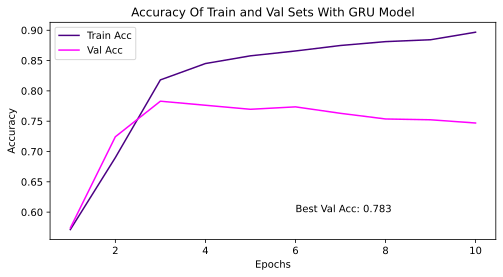

In [32]:
plt.figure(figsize=(8,4))
plt.title(f'Accuracy Of Train and Val Sets With GRU Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(history.history['val_accuracy']):.3} on epoch 3/10 with training accuracy of {history.history['accuracy'][2]:.3}")
   
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'indigo');
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'magenta')
plt.text(6, 0.6, f"Best Val Acc: {max(history.history['val_accuracy']):.3}" )
plt.legend(['Train Acc', 'Val Acc'])
    
plt.show()

# Results

The criterion we'll use to choose a "best" model from among those we've built in this notebook is the performance based on submission to the competition and returns a score. Each model is trained for the number of epochs at which the point the validation accuracy is highest and at which the validtion and train data sets begin to diverge, indicating the model is beginning to overfit. 

To produce the predictions we will retrain the model and create predictions on the test set. 

The results listed below are from submitting the csv to the kaggle competition, grading the predictions accuracy on tweets from the test set.

In [109]:
def sig(x):
    """
    Converts float to int output above 0.5 threshold.
    """
    if x > 0.5:
        return 1
    else:
        return 0
    
px = model.predict(test_df['text'])

results =[]
for n in px:
    results.append(sig(n))
    
grdf = pd.DataFrame({'id':test_df['id'].to_list(), 'target':results})#.to_csv('wr_sub_gru.csv', index=False)
print(len(grdf))

102/102 [==============================] - 1s 12ms/step
3263


In [110]:
grdf.to_csv('wr_submission.csv', index=False)

In [111]:
print(f"Dense Model Score On Submission test Set: 0.7793")
print(f"Simplified LSTM Model Score On Submission test Set: 0.7744")
print(f"Complex LSTM Model Score On Submission test Set: 0.7726")
print(f"Complex LSTM Model With Added Dense Layers Score On Submission test Set: 0.7810")
print(f"GRU Model Score On Submission test Set: 0.7723")

Dense Model Score On Submission test Set: 0.7793
Simplified LSTM Model Score On Submission test Set: 0.7744
Complex LSTM Model Score On Submission test Set: 0.7726
Complex LSTM Model With Added Dense Layers Score On Submission test Set: 0.7810
GRU Model Score On Submission test Set: 0.7723


### Parameter / Hyperparameter Tuning

Because of the relatively small size of the data (especially compared to image processing) we have the freedom to explore at a few different methods for improving model performance. 

There are a few hyperparameters we can continue to tune, like batch size and model architecture, but after training all of these different models we'll just keep it simple and tune the Optimizer Learning Rate parameter for our Adam optimizer at levels of (0.0001, 0.001, 0.01) using our highest performing model from the list above: the Complex LSTM Model With Added Dense Layers.

Note I turned off the model output for this and we'll just plot the results. 

Best Val Acc: 0.744 with learning rate of 0.0001


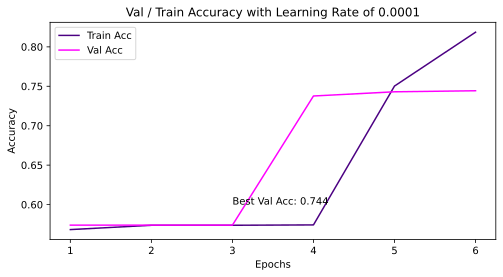

Best Val Acc: 0.778 with learning rate of 0.001


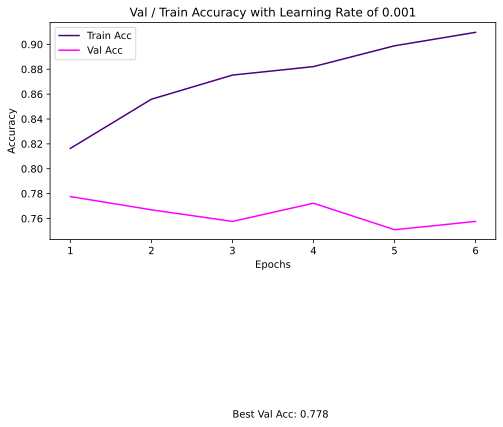

Best Val Acc: 0.783 with learning rate of 0.01


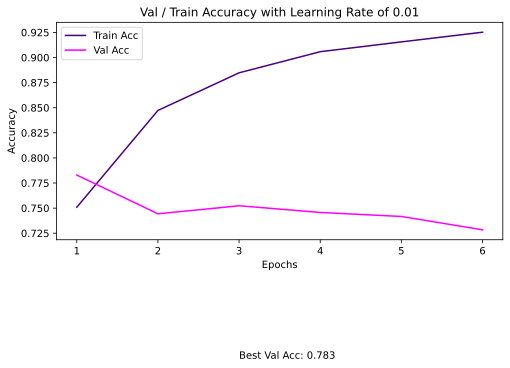

In [35]:
# Define model
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim= vocab_size+1,output_dim=max_len,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=False)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')])

for lr in [0.0001, 0.001, 0.01]:
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy',optimizer= opt, metrics=['accuracy'])
    history = model.fit(train_data, epochs=6, validation_data= val_data, verbose=0)
    
    print(f"Best Val Acc: {max(history.history['val_accuracy']):.3} with learning rate of {lr}")
    plt.figure(figsize=(8,4))
    plt.title(f'Val / Train Accuracy with Learning Rate of {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'indigo');
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'magenta')

    plt.legend(['Train Acc', 'Val Acc'])
    plt.show()



# Conclusions / Takeaways

The labeled test set for this competition has been leaked, so if you look on the leader board you will see several people with scores of 100%. Thus, the leaderboard results are kind of meaningless. 

All models had similar performance, both in evaluating on the validation set during training and in submissions to the competiton. Varying the model architecture did not produce many differences in performance for these models. The best model turned out to be our bi-directional LSTM wth added dense layers, but several other models were also close in performance. 

In the early part of working on this project I tested out several different combinations of tokenization hyperparameters such as the vocabulary size, num_words and also the max length of sequences passed to the model. These parameters changed the model results and training patterns a little but not much overall. for instance larger batch sizes decreased training time per epoch but the models started to need more epochs to converge with a higher batch size (up to 512). There may be a more optimal combination of these parameters, and indeed better text processing steps than the ones I chose, but I woul not expect tuning these parameters further to result in a large increase in  performance.

For tuning the learning rate hyperparameter the, we acheived the best results (in terms of validation set accuracy) with the largest learning rate of 0.01 but was not much differetn than the results we obtained with the 0.001 learning rate (0,778 v 0.783 validation accuracy). With the smallest learning rate of 0.0001 the model learned very slowly and could not easily converge. Based on these results I would recommend a learning rate of 0001-0.01 which may have different optima for the different models.

If I were to spend more time on this project I have a few ideas for how to improve performance:

Feature Engineering - Extract features from these tweets that could help the model learn to recognize real disaster tweets. For example try to extract the hashtags, identify novel key words and make the location feature more meaningful by grouping it by part of the world or splitting by highly developed or less developed countries. Skillfull feature engineering, rather than endlessly testing model parameters, would likely yield the most improvement. 

Test a few different model architectures, batch sizes and other hyperparameters. This could be a fruitful line of investigation but can only really succeed with better features. Varying the model architecture did not produce many differences in performance for these models, so I would not expect a new architecture to make a dramatic difference.

If this were a real world problem we could collect and label more data to train a better model, and even continuously stream, ingest new data and train more up to date models to build something that could work in real time. 